C:\Users\tejas\AppData\Local\Temp\ipykernel_21052\2360096139.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("faster_rcnn_finetuned.pth

Detected object: car, Confidence: 1.00, Box: [175.22646 159.92656 411.08838 273.40625]


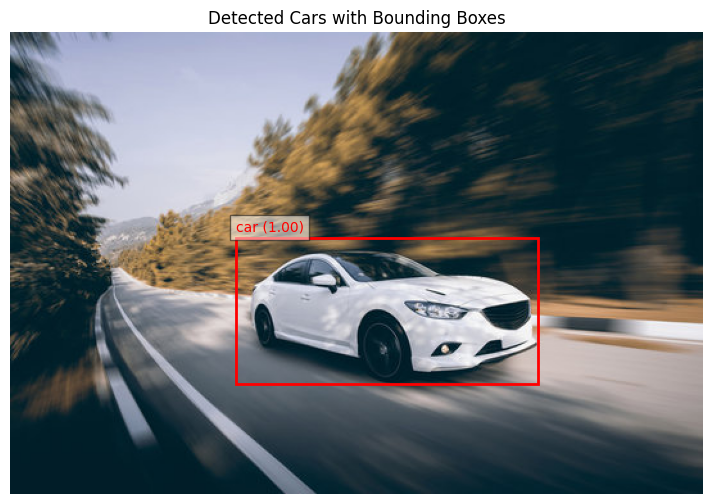

In [3]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the fine-tuned model
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2  # 1 class (car) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("faster_rcnn_finetuned.pth"))
model.to("cpu")
model.eval()

# Load test image
test_image_path = "car.jpg"  # Replace with your test image path
img = Image.open(test_image_path).convert("RGB")
img_tensor = ToTensor()(img)
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    prediction = model(img_tensor)

# Process predictions
boxes = prediction[0]['boxes'].numpy()
labels = prediction[0]['labels'].numpy()
scores = prediction[0]['scores'].numpy()

# Convert image to numpy array for plotting
img_np = np.array(img)

# Create a plot
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.imshow(img_np)

# Filter predictions and draw bounding boxes
confidence_threshold = 0.5
for box, label, score in zip(boxes, labels, scores):
    if score > confidence_threshold:
        # Print detection
        print(f"Detected object: {'car' if label == 1 else 'background'}, Confidence: {score:.2f}, Box: {box}")
        
        # Draw bounding box
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label and score
        label_text = f"{'car' if label == 1 else 'background'} ({score:.2f})"
        ax.text(x_min, y_min - 5, label_text, color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Remove axes for better visualization
ax.axis('off')
plt.title("Detected Cars with Bounding Boxes")
plt.savefig("output_image_with_boxes.png")  # Save the image
plt.show()